## Final Project Submission

Please fill out:
* Student name: Bert Tong
* Student pace: self paced 
* Scheduled project review date/time: 1/24/20, 3pm cst
* Instructor name: Jeff Hermans
* Blog post URL: https://medium.com/@bktong/hypotheses-testing-discounts-in-the-northwinds-dataset-ba2ef33825a3
* Github Repo: https://github.com/bktong/Mod-3-Hypothesis-Testing

# Project Intro
Summary: 
Using Northwinds database (included in this repo), use statistical analysis and hypothesis testing to generate valuable insights.

Deliverables:

- Answer the question: 
"Does discount amount have a statistically significant effect on the quantity of a product in an order?  If so at what level(s) of discount?

- Develop 3 more hypotheses and perform the necessary analysis.


# Project Outline

1.  Explore data (provided in the "Northwind_small.sqlite" db)
2.  Clean/Validate/Process data to fit our model(s)
3.  Questions to Answer (below)
4.  Evaluate and Prove/Disprove Hypothesis
5.  Conclusions and Takeaways

Summary of questions we will be trying to answer:
Q1 - "Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount"
Q2 - "Do Discounts impact quantity sold at a product level?"
Q3 - "Does the unit price impact the quanity of product sold?"
Q4 - "Does the shipping carrier matter?"

# 1. Data Exploration

Before we start digging, lets take a look at what our sql schema looks like and identify where we need to go.

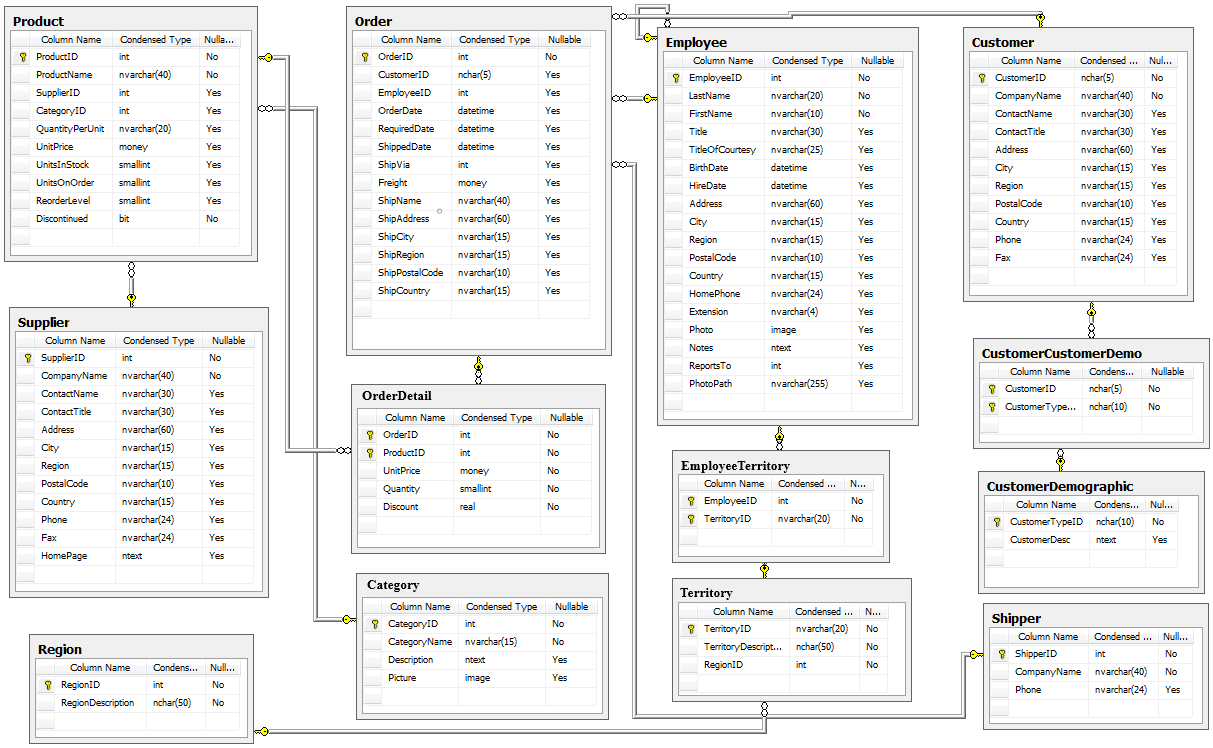

We need somewhere to start our data exploration, so we will take inspiration from our first question regarding the impact of discounts on sales.   That's the "OrderDetail" table, so let's pop our head over there.

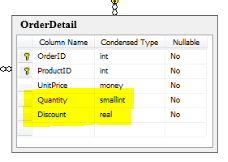

Great, it seems we have all the data we need in the OrderDetail table. 

In [1]:
# import necessary libraries.  

import pandas as pd 
import sqlite3 
import scipy.stats as stats 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # to hide our matplotlib warnings

# connect to our db.
url = "Northwind_small.sqlite"

conn = sqlite3.connect(url)
cur = conn.cursor()

In [2]:
# List all our tables

tables = cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]
print(tables)

['Employee', 'Category', 'Customer', 'Shipper', 'Supplier', 'Order', 'Product', 'OrderDetail', 'CustomerCustomerDemo', 'CustomerDemographic', 'Region', 'Territory', 'EmployeeTerritory']


In [3]:
# importing the whole OrderDetail table to a pandas dataframe gives us a jumping in point to begin our exploration

cur.execute("SELECT OrderID, ProductID, UnitPrice, Quantity, Discount FROM OrderDetail")
OrderDetail_df = pd.DataFrame(cur.fetchall())
OrderDetail_df.columns = [x[0] for x in cur.description]
OrderDetail_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [4]:
# add total price column

OrderDetail_df["total_price"] = OrderDetail_df["UnitPrice"]*OrderDetail_df["Quantity"]*(1-OrderDetail_df["Discount"])
OrderDetail_df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,total_price
0,10248,11,14.0,12,0.0,168.0
1,10248,42,9.8,10,0.0,98.0
2,10248,72,34.8,5,0.0,174.0
3,10249,14,18.6,9,0.0,167.4
4,10249,51,42.4,40,0.0,1696.0


Some quick things from OrderDetail to keep in mind as we move forward

- we have 2155 single product entries (1 order number may contain multiple line entries)
- Unit Price's standard deviation is > its mean
- quantity is also amost as extreme of a standard deviation/mean
- discounts range between 0 - 25%

In [5]:
# Lets see what percentage of our sales are discounted?  Since our samples are not the same size 
# we will have to use Welch's T-test to provide a more accurate p-value.

percentHasDiscount = 100 * sum(OrderDetail_df["Discount"]>0)/len(OrderDetail_df)
percentHasDiscount

38.88631090487239

In [6]:
# We systematically explored each of the sql tables, but have removed them from this notebook as they were unnecessary 
# to our analysis.

# Here, we explore the Orders Table.  Note we needed to use the quotes around Order as it is a 
# reserved word in SQL (boo on whoever created that table name)

cur.execute("SELECT * FROM 'Order'")
Order_df = pd.DataFrame(cur.fetchall())
Order_df.columns = [x[0] for x in cur.description]
Order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


Two datapoints that jumped out at me are the "ShipVia" and "ShipRegion" columns.   They both seem to have some limited discrete values that we could dive into exploring.

In [7]:
# exploring our carrier,  should make a difference.

Order_df.ShipVia.value_counts()

2    326
3    255
1    249
Name: ShipVia, dtype: int64

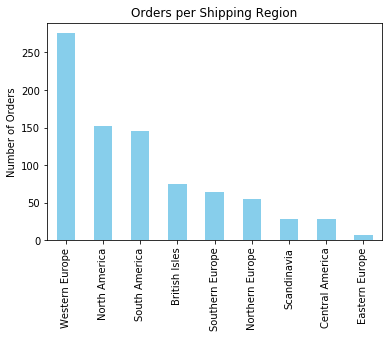

In [8]:
# where do our orders go?

shipRegions = Order_df.ShipRegion.value_counts()
shipRegions.plot(kind = "bar", color = "skyblue")

plt.title('Orders per Shipping Region')
plt.ylabel('Number of Orders')
plt.show()

Summary: We ended up repeating the explore process for every table in the db, but in the end only used data from the Order and OrderDetail tables.   In an effort to not prolong this notebook, all the unnecessary exploration has been removed from this notebook.

# 2. Clean / Validate Data

It is a lot of space if we show all of our data scrubbing process.  However we ended up not needing any datapoints that were missing for our analysis.   Lesson learned:  Determine the scope of the project before you begin sanitizing your data.  If you can get away with strategically clean data, that's less work that needs to be done.

OrderDetail, nothing to clean
Order, 21 shipping date NaNs, 19 shipping code NaNs

In [9]:
# validate that our OrderDetails table is clean

# OrderDetail_df.isna().sum()  #commented out as there was nothing to sanatize
Order_df.isna().sum()

Id                 0
CustomerId         0
EmployeeId         0
OrderDate          0
RequiredDate       0
ShippedDate       21
ShipVia            0
Freight            0
ShipName           0
ShipAddress        0
ShipCity           0
ShipRegion         0
ShipPostalCode    19
ShipCountry        0
dtype: int64

summary:  We only cared about freighter used and shipping region, so all other columns were dropped.

# 3 - Questions We Are Looking to Answer:
Since we're treating you the reader as a decision maker in the company, lets keep to business related questions.

Here we are keeping to business questions we ask and during our evaluation we will translate the questions so
we can use our statistical analysis to answer them.

Q1 - Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount"
This was a mandatory question to answer for the project, but it makes sense to see if we should explore discounting further.

Q2 - "Does discounting impact individual skus?"
Our first questions is looking at order quantity as a whole, but in business we want to know how individual products behave.

Q3 - "Does our product catalog demonstrate price elasticity of demand? Highlight skus to further explore" 
Where we are really getting with this is understanding if we are maximizing revenues or just introducing  pricing disparity for the sake of doing so.

Q4 - "Where should we prioritize our sales efforts?"
Is our sales team where they should be?

# 4 - Evaluation
Let's now break down question into something we can answer using statistical analysis.    

Q1 - "Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount"
    Null Hypothesis:   Mean Quantity of orders in Discounted and Non-discounted samples are equal. 
    Alternative Hypothesis:  Given any discount, the discounted group will have larger quantity ordered.
    Alpha = 0.05

Q2 - "Do Discounts impact quantity sold at a product level?"
Q3 - "Does the unit price impact the quanity of product sold?"
Q4 - "Does the shipping region matter?"

# Q1:  Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

For this question, it is asking for us to combine a bunch of skills we have been learning to resolve.  (Data wrangling
from sql, df manipulation, grouping variables, and then statistical analysis).  We already explored the OrderDetails table in phase 1 of the project so it makes sense to just refocus on that table.  Let's break down specifically what it is asking.

- The impact of ANY level of discount on the quantity in an order. Basically, anyorder where Discount != 0.
- We have to define the definition of an Order.  Here are some options.
    - An order can be specifically one row of our dataframe.
    - An order can be defined as all products sold under a unique OrderId.

after we separate our groups, we will then run a ttest to determine the p-value.   


In [10]:
# Null Hypothesis:   Mean Quantity of orders in Discounted and Non-discounted samples are equal. 
# Alternative Hypothesis:  Given any discount, the discounted group will have larger quantity ordered.
# alpha: 0.05

# reference for our ttest is found at https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [11]:
# let's look at our results if we do one dataframe line at a time.  

# first we separate our two groups by discount.

fp_orders_df = OrderDetail_df[ OrderDetail_df["Discount"] == 0.0].Quantity
disc_orders_df = OrderDetail_df[ OrderDetail_df["Discount"] > 0.0].Quantity
print(fp_orders_df.head())
print(disc_orders_df.head())

0    12
1    10
2     5
3     9
4    40
Name: Quantity, dtype: int64
6     35
7     15
8      6
9     15
11    40
Name: Quantity, dtype: int64


In [12]:
# we use Welch's test here because from our earlier analysis we do not have equivalent sample sizes.
# We divide by 2 because we only care about Increase in quantity.

w = stats.ttest_ind(fp_orders_df, disc_orders_df, equal_var=False)
print(w.pvalue/2)


2.828207145152165e-10


Conclusion:   We reject the null hypothesis as our pvalue is less than 0.05.  

Quantity observes a statistically significant increase in the presence of a discount. 

# Q1, part 2 - If so, At what level(s) of discount?

In [13]:
# lets see what levels of discounts present.
print(OrderDetail_df.Discount.value_counts())

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64


In [14]:
# so we will use discounts of [0.05, 0.1, 0.15, 0.2, 0.25].  All other levels we do no have the datapoints to run
# our analysis.

discount_list = [0.05, 0.1, 0.15, 0.2, 0.25]
pvalues = []
fp_orders_df = OrderDetail_df[ OrderDetail_df["Discount"] == 0.0].Quantity

for i in discount_list:
    
    disc_orders_df = OrderDetail_df[ OrderDetail_df["Discount"] == i].Quantity  # recreate our temp df for each discount level
    w = stats.ttest_ind(fp_orders_df, disc_orders_df, equal_var=False)
    pvalues.append((i, w.pvalue/2))

pvalues

[(0.05, 0.00013616747216423796),
 (0.1, 0.0187279830531704),
 (0.15, 8.610364721813697e-05),
 (0.2, 0.0004055016627021704),
 (0.25, 7.961525461062818e-05)]

Conclusion: Reject null hypothesis at all levels of discount.   
    
We see a statistical significant increase in quantity at all levels of discount.   Lets take a quick peak at how things change if we used the other definition of "Order"

As a reminder, we defined it as All products with the same OrderID.   

In [15]:
# When we initially explored our data, we saw a single Order ID could have multiple product ids.  
# and each ProductID would have different quantities.  
# Therefor, We need to group them together so we can calculate the sum quantity of an order.  

df = OrderDetail_df.groupby("OrderId").sum()
df.head()

,ProductId,UnitPrice,Quantity,Discount,total_price
OrderId,,,,,
10248,125,58.6,27,0.0,440.00
10249,65,61.0,49,0.0,1863.40
10250,157,66.9,60,0.3,1552.60
10251,144,49.2,41,0.1,654.06
10252,113,94.0,105,0.1,3597.90


In [16]:
# now we can follow our previous process and separate our sample into 2 groups (discounts vs non-discounts)

fp_orders_df = df[ df["Discount"] == 0.0].Quantity
disc_orders_df = df[ df["Discount"] > 0.0].Quantity

print(fp_orders_df.head())
print(disc_orders_df.head())

OrderId
10248     27
10249     49
10253    102
10255    110
10256     27
Name: Quantity, dtype: int64
OrderId
10250     60
10251     41
10252    105
10254     57
10258    121
Name: Quantity, dtype: int64


In [17]:
w = stats.ttest_ind(fp_orders_df, disc_orders_df, equal_var=False)
print(w.pvalue/2)

2.925338907945559e-09


Our pvalue < alpha (0.05) so we can still reject the null hypothesis 

Conclusion:  We reject the Null Hypothesis.  There IS a statistically significant difference in quantity per order

# Q1.3 - What about discount on top line sales?

It's a business right?  Revenue probably matters more than quantity sold (Unless we were the dollar store).  So see if discounting has a significant impact on revenue per order.


In [18]:
# Null Hypothesis:   Discount level has no effect on the total revenue per order.  
# Alt Hypothesis:  The discounted group will have larger order revenues given any sort of discount
# alpha: 0.05

In [19]:
# separate again to discount and non-discount, group by their OrderId to sum revenue per ticket.
fp_orders_df = OrderDetail_df[ OrderDetail_df["Discount"] == 0.0].groupby("OrderId").sum().total_price.copy()
disc_orders_df = OrderDetail_df[ OrderDetail_df["Discount"] > 0.0].groupby("OrderId").sum().total_price.copy()

print(fp_orders_df.head())
print(disc_orders_df.head())

OrderId
10248     440.0
10249    1863.4
10250      77.0
10251     336.0
10252    1088.0
Name: total_price, dtype: float64
OrderId
10250    1475.60
10251     318.06
10252    2509.90
10254     388.62
10258    1614.88
Name: total_price, dtype: float64


In [20]:
# rerun our ttest with total ticket value

w = stats.ttest_ind(fp_orders_df, disc_orders_df, equal_var=False)
print(w.pvalue/2)

0.11604300297234528


Conclusion:   We accept the Null Hypothesis as pvalue > alpha, (0.11 > 0.05).

Interesting. We can continue to repeat the previous processes, but it seems that like with any statistics, the real key to supporting a theory is all in how you write the question.  

# Question 2: What is the impact of discounts for each individual product?
If I were consulting a company, I would want to understand impact not at the order level, but rather at the SKU level.  For Northwinds, this means understanding how discounting impact individual ProductIDs.

During our exploration phase, we found 77 different ProductIds represented our entire catalog.   For those with large sample size, we can explore the impact of our discounting behavior at a more granular level.  


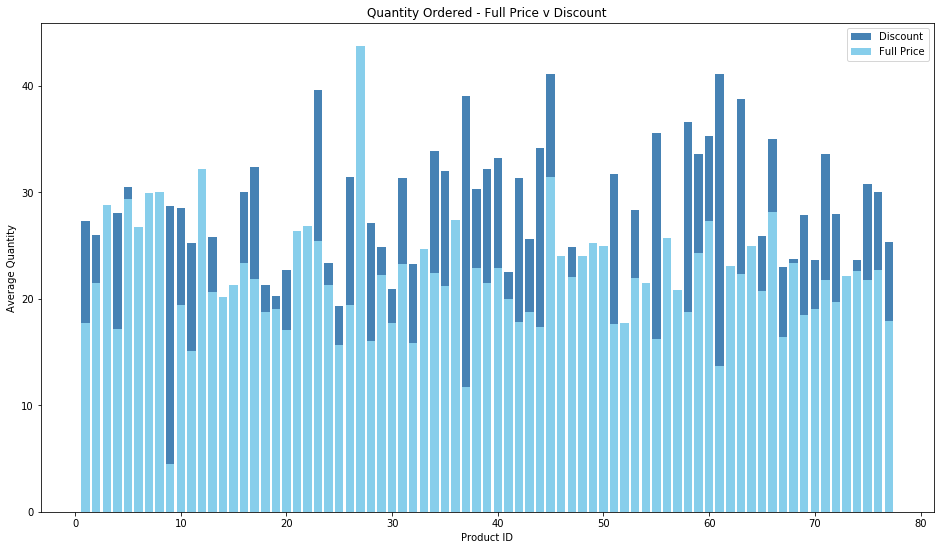

In [21]:
# visualizing discount breakdown for our catalog.

d = OrderDetail_df[OrderDetail_df['Discount']>0].groupby('ProductId')['Quantity'].mean()
f = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(16,9))
plt.bar(d.index, d.values, label='Discount', color='steelblue')
plt.bar(f.index, f.values,  label='Full Price', color='skyblue')
plt.legend()
plt.title('Quantity Ordered - Full Price v Discount')
plt.xlabel('Product ID')
plt.ylabel('Average Quantity')
plt.show()

In [22]:
# For each product ID we will have the same null/alternative hypothesis.  

# Null Hypothesis:   Discount level has no effect on the quantity of a particular product ordered.   
# Alt Hypothesis:  The discounted group will have more product ordered given any sort of discount
# alpha: 0.05

In [23]:
# Note: when msft created the northwinds db, numerically sequenced ProductID from 1-77.  Very Convenient!

pid_range = 77
pid_impact = []
alpha = 0.05 

for i in range(pid_range):
    
    # getting orders for where product id == iterator and reusing the single line code to isolate our 
    pid = OrderDetail_df["ProductId"] == (i+1)
    full_price = (OrderDetail_df["Discount"] == 0)
    discount = (OrderDetail_df["Discount"] > 0)
    full = OrderDetail_df[pid & full_price].Quantity
    disc = OrderDetail_df[pid & discount].Quantity
    
    # run the ttest
    w = stats.ttest_ind(disc, full, equal_var = False)
    #print ( "product " + str(i+1) + " pval = " + str(w.pvalue/2)) 
    
    if w.pvalue/2 < alpha:  # store the productIds where we reject the null
        pid_impact.append ( [i+1, w.pvalue/2])
    else:
        #print (("PID: " +str(i+1)))
        pass

print ("Null hypothesis is rejected for " + str(len(pid_impact)) + " of 77 productIDs")

pid_impact  #uncomment this line if you want to observe the pvalues for each individual productId

Null hypothesis is rejected for 11 of 77 productIDs


[[4, 0.04874384506140404],
 [7, 0.047046744593322004],
 [11, 0.033668269594431394],
 [26, 0.03646993644152816],
 [55, 0.018400805342093693],
 [57, 0.007774708658226876],
 [58, 0.01018632037591415],
 [61, 0.025070834052456692],
 [69, 0.042549902992462786],
 [71, 0.03827603768105477],
 [72, 0.04762864957505023]]

Our results state that we can 66 of our 77 productIDs accept the null hypothesis as they could not clear the alpha hurdle (0.05). 

Now, this is a bit confusing and I'm not sure what the make of the results.  From a statistical analysis standpoint we can reject the null hypothesis for the 11 productsIDs listed above, but that doesn't sit well with me when we had such a small p-value for question 1.   

Lets explore further.

In [24]:
# exploring the first product (pid == 1) we can see that the same product id has multiple unit prices 
# in addition to multiple discount levels.

pid1 = OrderDetail_df[OrderDetail_df["ProductId"] == (1)]
print (pid1.UnitPrice.value_counts())
print (pid1.Discount.value_counts())

# pid1  # commented out, but we viewed this to see just how much variation is across a single product ID 

18.0    29
14.4     9
Name: UnitPrice, dtype: int64
0.00    22
0.15     5
0.25     5
0.20     4
0.05     1
0.10     1
Name: Discount, dtype: int64


When we explore individually all values for ProductID == 1, we see that unit prices for the same thing are not consistent.  Some are at $14.4/unit while others are at 18/unit.  Discount levels are inconsistently spread out across both pricing levels as well.   This is true for most all other PIDs.

We could explore further, but it is our suspicion that pricing/discounting inconsistencies contribute to the so many productIds not being impacted by discounting.  This leads us to question 3.

# Q3 - Impact of unit price on quantity
Each product sold by NorthWinds has a "max" unit price (base price), so if we conceptually look at "discounting" as anything less than our max price, we will be able to see the full impact of price on the quantity of product sold.

We will thus separate our two groups into Max Price (max value), discount (< Max Price).


In [25]:
# For each product ID we will have the same null/alternative hypothesis.  

# Null Hypothesis:   Price has no effect on the quantity of a particular product ordered.   
# Alt Hypothesis:  The discounted group will have more product ordered given any sort of discount
# alpha: 0.05

In [26]:
# let put in a new column that calculates paid_unit_price
OrderDetail_df["paid_unit_price"] = OrderDetail_df["UnitPrice"]*(1-OrderDetail_df["Discount"])

# lets explore ProductID 1 again before moving on.
pid1 = OrderDetail_df[OrderDetail_df["ProductId"] == (1)]
pid1.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,total_price,paid_unit_price
99,10285,1,14.4,45,0.20,518.4,11.52
123,10294,1,14.4,18,0.00,259.2,14.40
184,10317,1,14.4,20,0.00,288.0,14.40
269,10348,1,14.4,15,0.15,183.6,12.24
282,10354,1,14.4,12,0.00,172.8,14.40


In [27]:
# rerun our loop for each PID and use "paid_unit_price" to filter our groups
pid_range = 77
pid_impact = []

for i in range(pid_range):
    # remember that i starts at 0 so we will want to add 1 each time.
    
    # getting orders for where product id == iterator and reusing the single line code to isolate our 
    pid = (OrderDetail_df["ProductId"] == (i+1))
    maxPrice = OrderDetail_df[OrderDetail_df["ProductId"] == (i+1)].paid_unit_price.max()
    full_price = (OrderDetail_df["paid_unit_price"] == maxPrice)
    discount = (OrderDetail_df["paid_unit_price"] < maxPrice)
    full = OrderDetail_df[pid & full_price].Quantity
    disc = OrderDetail_df[pid & discount].Quantity
    
    # run the ttest
    w = stats.ttest_ind(disc, full, equal_var = False)
    #print ( "product " + str(i+1) + " pval = " + str(w.pvalue/2)) 

    
    if w.pvalue/2 < 0.05:
        pid_impact.append ( [i+1, w.pvalue/2])
    else:
        #print (("PID: " +str(i+1)))
        pass
print ("Null hypothesis is rejected for " + str(len(pid_impact)) + " of 77 productIDs")

pid_impact  

Null hypothesis is rejected for 10 of 77 productIDs


[[2, 0.029934161028221915],
 [4, 0.027343336307779752],
 [7, 0.04367713498642763],
 [11, 0.04566479927929218],
 [22, 0.019335065834336848],
 [35, 0.031908780678885876],
 [51, 0.04029773942657505],
 [55, 0.027947319659824218],
 [58, 0.020399313217868607],
 [61, 0.01700867918788108]]

Conclusion:  We can reject the null hypothesis in only 10 of the 77 Products.   For 67 of productIDs, paying less than full price does not have a statistically significant impact on quantity purchased.  This does make jive with the visualization we first explored in this project as some product Ids are heavily impacted by discounts while others are not.

# Q4 - Can we explore something that isn't a discount?

All kidding aside, lets take a look at if there is a better shipping company?  While we do not have a "receive date" to calculate the end to end logistics time of our transations, we do have order dates and shipping dates so we can easily calculate processing time for the handling part of "shipping and handling."

Another easy thing to check is if our orders shipped "on time" (shipped date < requiredDate)


In [28]:
# Null Hypothesis:   There is no difference in processing time between carriers  
# Alt Hypothesis:  There is a difference in processing time between carriers  
# alpha: 0.05

In [29]:
# Starting clean with a freshly reloaded Order table.

cur.execute("SELECT * FROM 'Order'")
Order_df = pd.DataFrame(cur.fetchall())
Order_df.columns = [x[0] for x in cur.description]
Order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [30]:
# we know that there were a few rows with NaN values in Shipped Date, so we can drop the < 1% that had NaNs 
# and still have a good enough sized sample.

Order_df = Order_df.dropna()

In [31]:
# logistics time = order date to received date()

# before we calculate, we need to convert date time to something numeric.

# convert the 'Date' column to datetime format 
Order_df['ShippedDate'] = pd.to_datetime(Order_df['ShippedDate']) 
Order_df['OrderDate'] = pd.to_datetime(Order_df['OrderDate']) 

In [32]:
# our processing time is time beteween when something is ordered and when something is shipped.

Order_df["logistics"] = Order_df["ShippedDate"] - Order_df["OrderDate"]

In [33]:
# so our logistics column is now in a timedelta format and we need to convert it back to an integer for our analysis.

Order_df["logistics"] = Order_df["logistics"].dt.days


In [34]:
# verify that we were successful in changing the datatype

Order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790 entries, 0 to 821
Data columns (total 15 columns):
Id                790 non-null int64
CustomerId        790 non-null object
EmployeeId        790 non-null int64
OrderDate         790 non-null datetime64[ns]
RequiredDate      790 non-null object
ShippedDate       790 non-null datetime64[ns]
ShipVia           790 non-null int64
Freight           790 non-null float64
ShipName          790 non-null object
ShipAddress       790 non-null object
ShipCity          790 non-null object
ShipRegion        790 non-null object
ShipPostalCode    790 non-null object
ShipCountry       790 non-null object
logistics         790 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(4), object(8)
memory usage: 74.1+ KB


In [35]:
# clean up our df and view only whats needed, using df so we don't have to reload our Ordertable if we make a mistake.

df = Order_df.drop(columns = ["Id", "CustomerId", "EmployeeId", "Freight", "ShipName", "ShipAddress", "ShipCity", 
        "ShipPostalCode"]).copy()

In [36]:
df.head()

,OrderDate,RequiredDate,ShippedDate,ShipVia,ShipRegion,ShipCountry,logistics
0,2012-07-04,2012-08-01,2012-07-16,3,Western Europe,France,12
1,2012-07-05,2012-08-16,2012-07-10,1,Western Europe,Germany,5
2,2012-07-08,2012-08-05,2012-07-12,2,South America,Brazil,4
3,2012-07-08,2012-08-05,2012-07-15,1,Western Europe,France,7
4,2012-07-09,2012-08-06,2012-07-11,2,Western Europe,Belgium,2


In [37]:
print(df.logistics.describe())
print(df.info())

count    790.000000
mean       8.431646
std        6.722624
min        1.000000
25%        4.000000
50%        7.000000
75%        9.000000
max       37.000000
Name: logistics, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 790 entries, 0 to 821
Data columns (total 7 columns):
OrderDate       790 non-null datetime64[ns]
RequiredDate    790 non-null object
ShippedDate     790 non-null datetime64[ns]
ShipVia         790 non-null int64
ShipRegion      790 non-null object
ShipCountry     790 non-null object
logistics       790 non-null int64
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 40.1+ KB
None


In [38]:
# Now lets apply an anova table

# loading our libraries for anova
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols

In [39]:
# Create the formula and run anova

formula = "logistics ~ C(ShipVia)"
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ = 2)
print(table)

                  sum_sq     df         F    PR(>F)
C(ShipVia)    440.440193    2.0  4.921243  0.007516
Residual    35217.368667  787.0       NaN       NaN


Answer:  With our pvalue being 0.007, we can reject the null hypothesis that all carriers take the same amount of processing time.  In otherwords, if logistics times matter, choose your carrier wisely.

# Conclusion

In this project, we explored multiple ways a discount at any level would impact our business as a whole (increase quantity of items ordered, increase in revenue)

In summation:
- q1 - Null Rejected:  discount impacts overall quantity of products ordered, but accepted when we explored revenue
- q2 - Null mostly accepted (11 of 77 cases):  When dig a bit deeper and examine things on a productID level, we can only find statistical significance in a minority of cases.
- q3 - Null mostly accepted (10 of 77 cases):  We noticed that discounting and pricing were two separate things and wanted to explore if the overall price paid impacted our quantity ordered.  It does seem there are a few products that where pricing matters, but as a whole, our portfolio seems inelastic to price.
- q4 - Null Rejected:  Not all carriers perform equally.  Understanding logistics timelines can help us improve customer satisfaction and be transparent about our delivery expectations. 

